In [ ]:
# For deep neural networks
import tensorflow.compat.v1 as tf

# For data representation
import numpy as np
import random

# For handling files
import os

# For plotting graphs
import matplotlib
import matplotlib.pyplot as plt



In [3]:
# OpenAI Gym
import gym
import random
env = gym.make("Asterix-v0")
# I have installed pyglet-1.5.11 for it work with BigSur

**Naive Agent**

In [3]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box([[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [2

The observation space is an RGB picture of size 210x160 whereas the action space is composed of the 18 possible moves from an ATARI controller. The info dictionary contains `ale.lives()` which refers to the number of lives left (but here there is no finite number of lives).

1.2. Create a simple agent that performs random actions.

In [4]:
class RandomAgent():
    def __init__(self, env):
        self.action_size = env.action_space.n
        
    def get_action(self, observation):
        return random.choice(range(self.action_size))
    
total_reward=0
agent = RandomAgent(env)
numberOfEpisodes = 10
for steps in range(numberOfEpisodes):
    current_obs = env.reset()
    done = False
    while not done:
        action = agent.get_action(current_obs)
        next_obs, reward, done, info = env.step(action)
        total_reward += reward
        env.render()
print("Average reward: {}".format(total_reward/numberOfEpisodes))

C:\Users\Dell\anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


Average reward: 215.0


**Deep Q-Learning Agent**

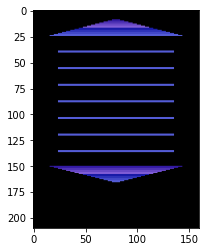

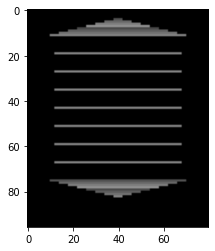

In [5]:
obs = env.reset()

def preprocess_observation(observation):
    img = observation[1:192:2, ::2] #This becomes 96, 80,3
    img = img.mean(axis=2) #to grayscale (values between 0 and 255)
    img = (img - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(96, 80, 1)

plt.imshow(obs)
plt.show()
plt.imshow(preprocess_observation(obs).reshape(96,80), cmap='gray', vmin=-128, vmax=127)
plt.show()

In [6]:
def q_network(X_state, name):
    prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
    initializer = tf.variance_scaling_initializer()
    with tf.variable_scope(name) as scope:
        prev_layer = tf.layers.conv2d(prev_layer, filters=32, 
                                      kernel_size=8,strides=4,
                                      padding="SAME" ,
                                      activation=tf.nn.relu,
                                      kernel_initializer=initializer)
        prev_layer = tf.layers.conv2d(prev_layer, filters=64,
                                      kernel_size=4,strides=2,
                                      padding="SAME" ,
                                      activation=tf.nn.relu,
                                      kernel_initializer=initializer)
        prev_layer = tf.layers.conv2d(prev_layer, filters=64,
                                      kernel_size=3,strides=1,
                                      padding="SAME" , 
                                      activation=tf.nn.relu,
                                      kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1,64 * 12 * 10])
        hidden = tf.layers.dense(last_conv_layer_flat,512,
                                 activation=tf.nn.relu,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, env.action_space.n,kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [7]:
class QLearningAgent():
    def __init__(self, env, learning_rate = 0.001, momentum = 0.95):
        self.loss_val = np.infty
        self.action_size = env.action_space.n
        tf.reset_default_graph()
        tf.disable_eager_execution()
        self.discount_rate = 0.99
        self.checkpoint_path = "./my_dqn.ckpt"
        self.X_state = tf.placeholder(tf.float32, shape=[None, 96, 80,1])
        self.online_q_values, self.online_vars = q_network(self.X_state, name="q_networks/online")
        self.target_q_values, self.target_vars = q_network(self.X_state, name="q_networks/target")

        #The "target" DNN will take the values of the "online" DNN
        self.copy_ops = [target_var.assign(self.online_vars[var_name]) for var_name, target_var in self.target_vars.items()]
        self.copy_online_to_target = tf.group(*self.copy_ops)

        #We create the model for training
        with tf.variable_scope("train"):
            self.X_action = tf.placeholder(tf.int32, shape=[None])
            self.y = tf.placeholder(tf.float32, shape=[None, 1])
            self.q_value = tf.reduce_sum(self.online_q_values * tf.one_hot(self.X_action, self.action_size),axis=1, keepdims=True)
            
            #If the error is between 0 and 1, 
            self.error = tf.abs(self.y - self.q_value)
            self.clipped_error = tf.clip_by_value(self.error, 0.0, 1.0)
            self.linear_error = 2 * (self.error - self.clipped_error)
            self.loss = tf.reduce_mean(tf.square(self.clipped_error) + self.linear_error)
            
            
            
            self.global_step = tf.Variable(0, trainable=False, name='global_step')
            self.optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
            self.training_op = self.optimizer.minimize(self.loss, global_step=self.global_step)

        # Saving the session
        self.saver = tf.train.Saver()
        self.sess = tf.Session()
        if os.path.isfile(self.checkpoint_path + ".index"):
            self.saver.restore(self.sess, self.checkpoint_path)
        else:
            self.sess.run(tf.global_variables_initializer())
            self.sess.run(self.copy_online_to_target)
        
    #---- CHOSSING ACTION ----
    def get_action(self,q_values, step):
        epsilon = max(0.1, 1)
        if np.random.rand() < epsilon:
            return np.random.randint(self.action_size) # random action
        else:
            return np.argmax(q_values) # optimal action

    #---- TRAINING ----
    def train(self, state_val, action_val, reward, next_state_val, continues):
        # Compute next_qvalues  
        next_q_values = self.target_q_values.eval(feed_dict={self.X_state: np.array([next_state_val])})
        # Compute best rewards
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        # Compute target values
        y_val = reward + continues * self.discount_rate * max_next_q_values
        # Train the online DQN
        _, self.loss_val = self.sess.run([self.training_op, self.loss], feed_dict={self.X_state: np.array([state_val]), self.X_action: np.array([action_val]), self.y: y_val})

1.8. Train your network for $1,000,000$ training steps. Since the training process can take __a lot of time__, save your models every $1000$ training steps. You can choose to only train your model every $4$ frames instead of every frames.

In [9]:
agent = QLearningAgent(env)  
ep_rewards = []
total_reward = 0
n_steps = 10000  # total number of training steps
copy_steps = 5000
save_steps = 1000 

with agent.sess:
    while True:
        step = agent.global_step.eval()
        if step >= n_steps:
            break

        print("\r\tTraining step {}/{} ({:.1f})%\tLoss {:5f}".format(
            step,
            n_steps,
            step * 100 / n_steps, 
            agent.loss_val), end="")

        if done: # game over, start again
            obs = env.reset()
            ep_rewards.append(total_reward)
            total_reward = 0
            state = preprocess_observation(obs)

        total_perc = int(step * 100 / n_steps)
        
        # Online DQN evaluates what to do
        q_values = agent.online_q_values.eval(feed_dict={agent.X_state: [state]})
        action = agent.get_action(q_values, step)
        
        # Online DQN plays
        next_obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(next_obs)
        agent.train(state, action, reward, next_state, 1.0 - done)
        
        env.render()
        total_reward+=reward
        state = next_state

        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            agent.copy_online_to_target.run()

        # And save regularly
        if step % save_steps == 0:
            agent.saver.save(agent.sess, agent.checkpoint_path)


INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt
	Training step 9999/10000 (100.0)%	Loss 0.0017665

1.5) Print the evolution of the total number of rewards w.r.t. the episodes.

In [5]:
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = random.choice([0,1,2,3,4,5])
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Rewards:{}'.format(episode, score))
env.close()

Episode:1 Rewards:200.0
Episode:2 Rewards:200.0
Episode:3 Rewards:450.0
Episode:4 Rewards:200.0
Episode:5 Rewards:100.0


References :-
    https://abdn.blackboard.com/ultra/courses/_54210_1/cl/outline  (Tutorial 3)
    